# Test Recurrent Policy with Extreme Parameter Variation 

In [7]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../Asteroid3dof_env')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/RL_Meta-Learning-master/Experiments/Asteroid_3DOF/Asteroid_PV_sphere


In [8]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

3-dof dynamics model
lander model apf
Glideslope Constraint: delta =  3
Flat Constraint


<IPython.core.display.Javascript object>


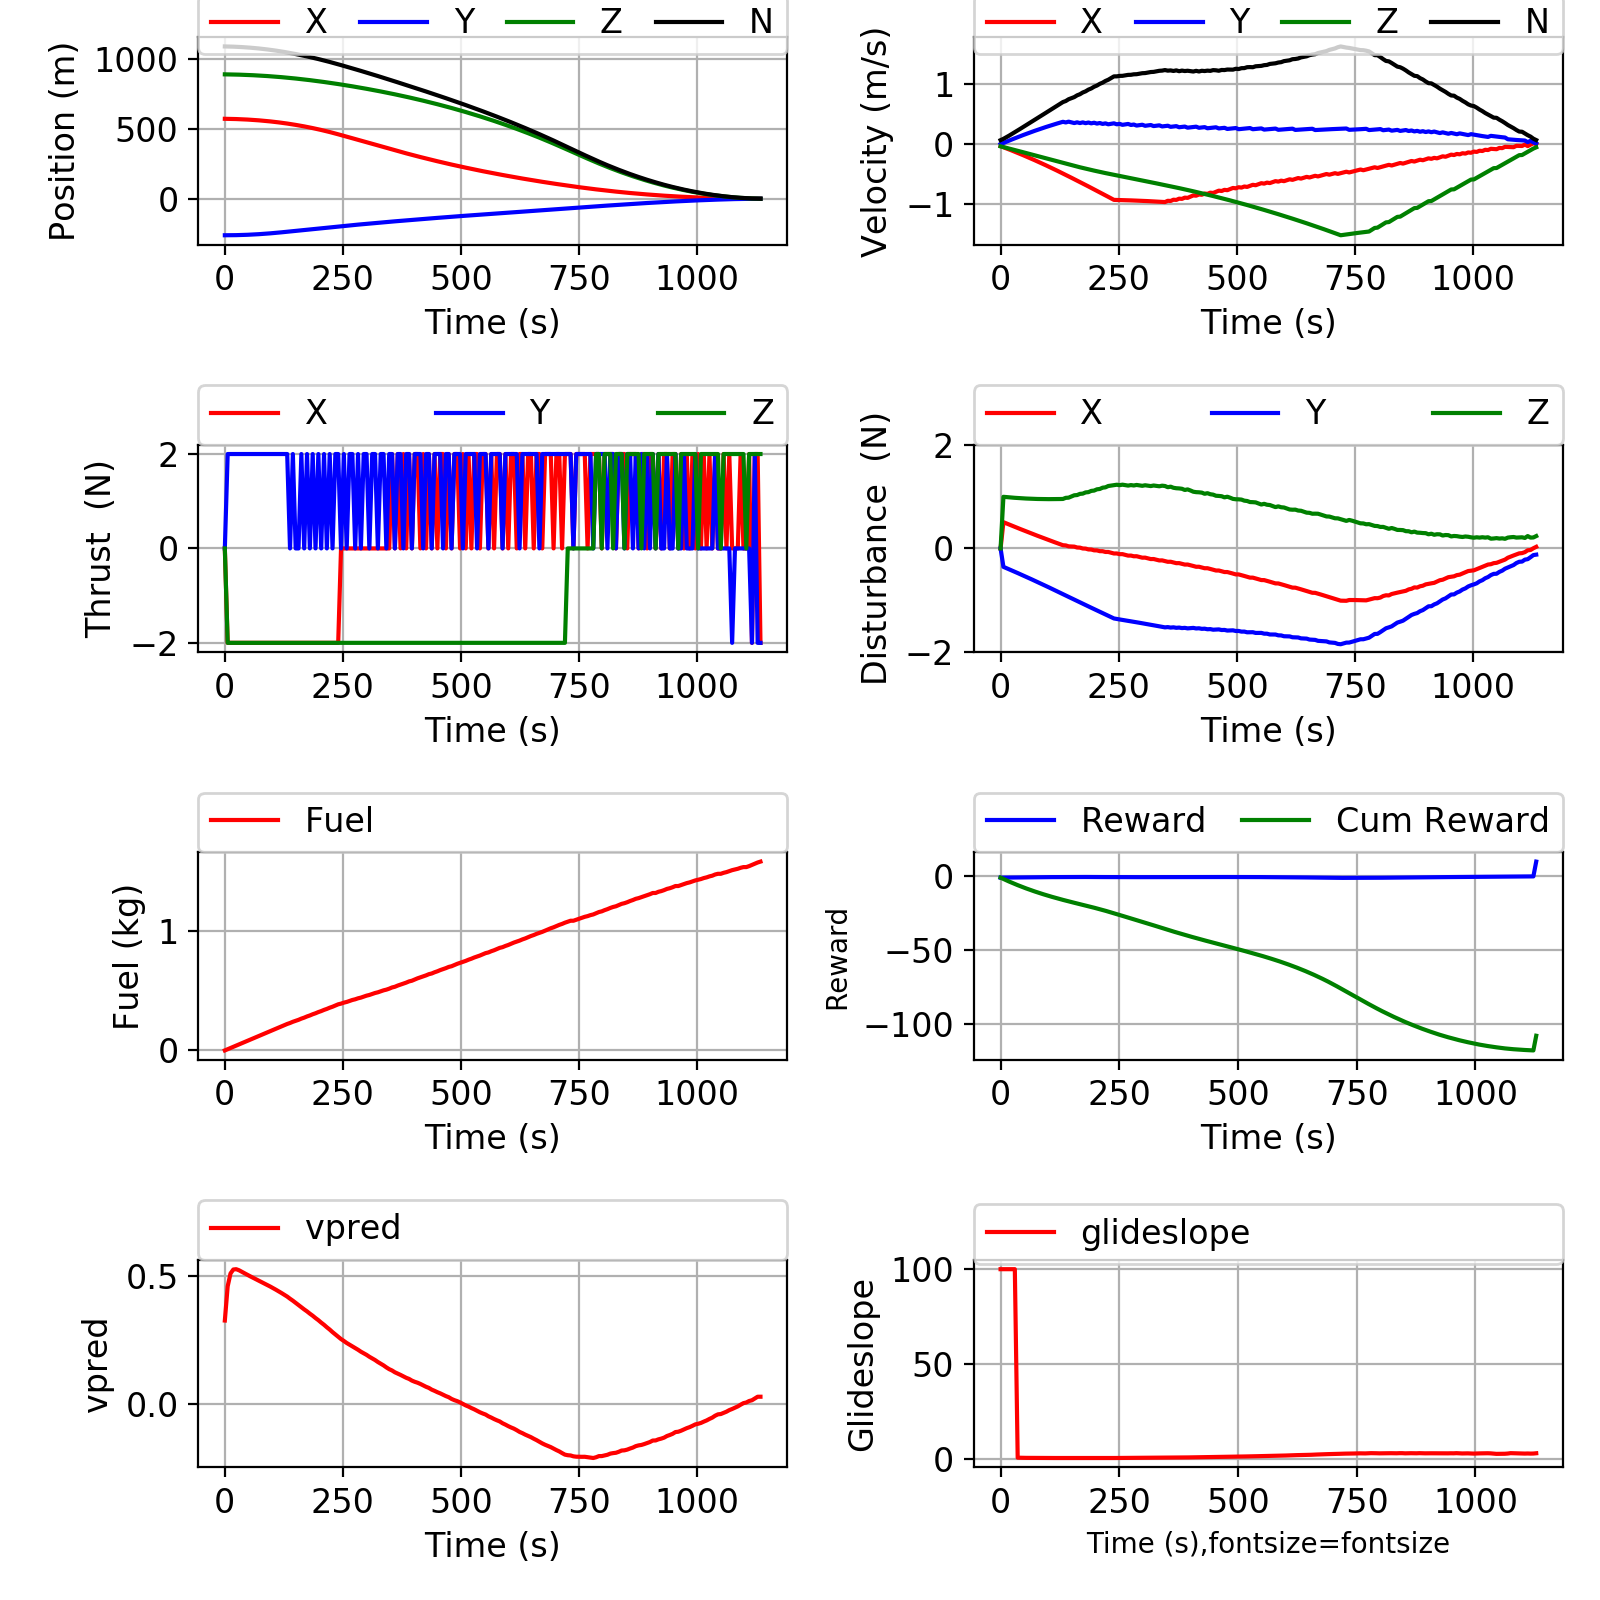

<IPython.core.display.Javascript object>


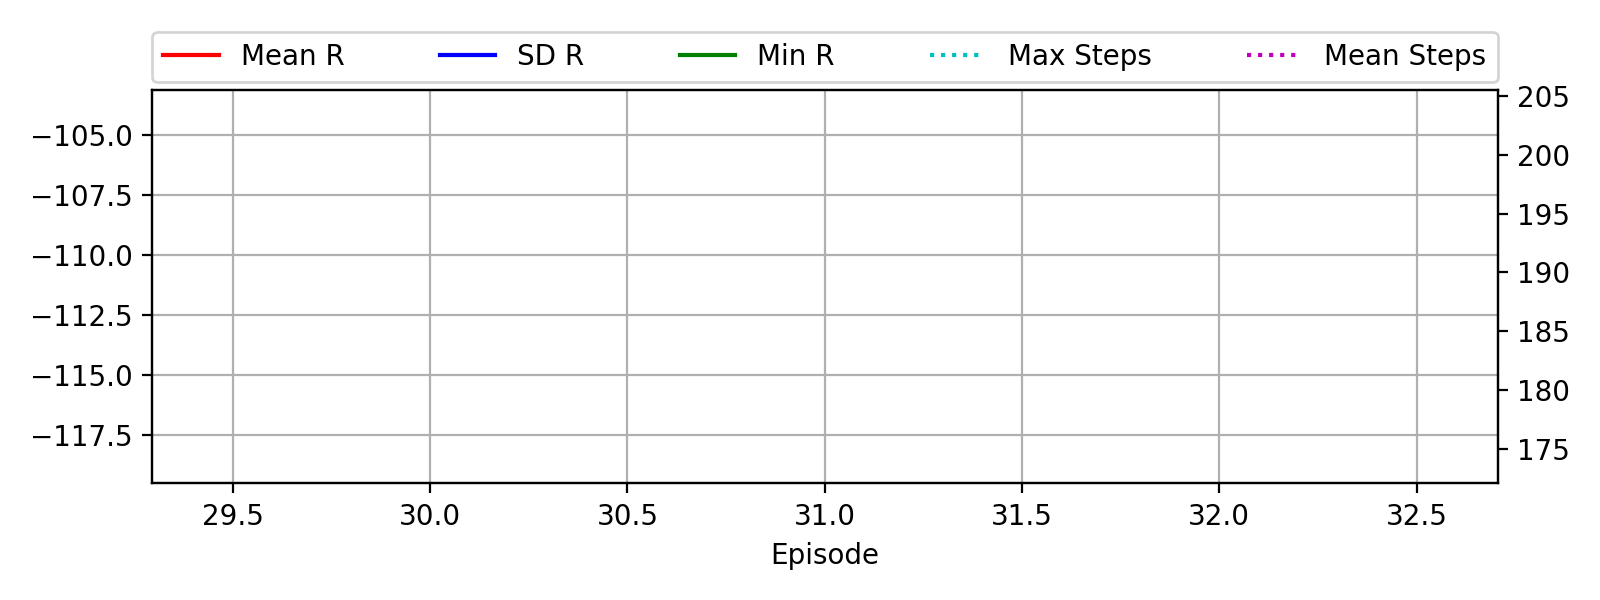

<IPython.core.display.Javascript object>


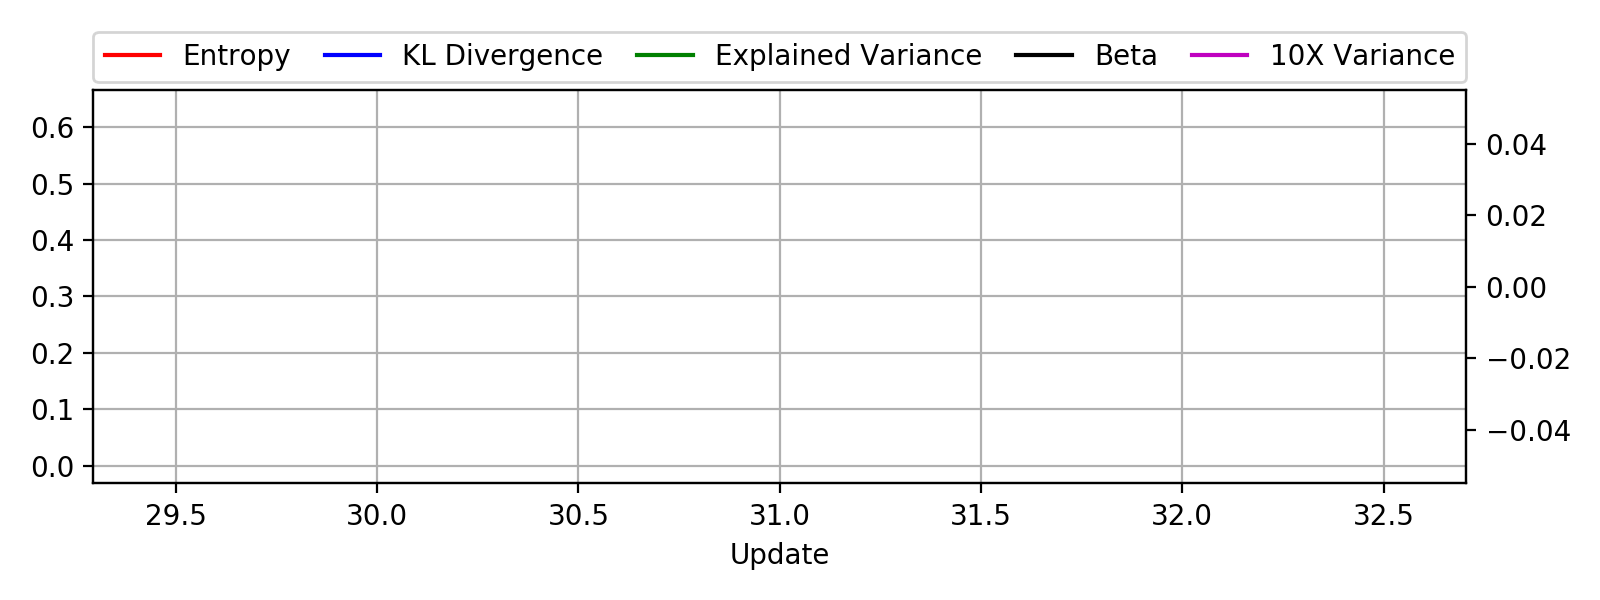

<IPython.core.display.Javascript object>


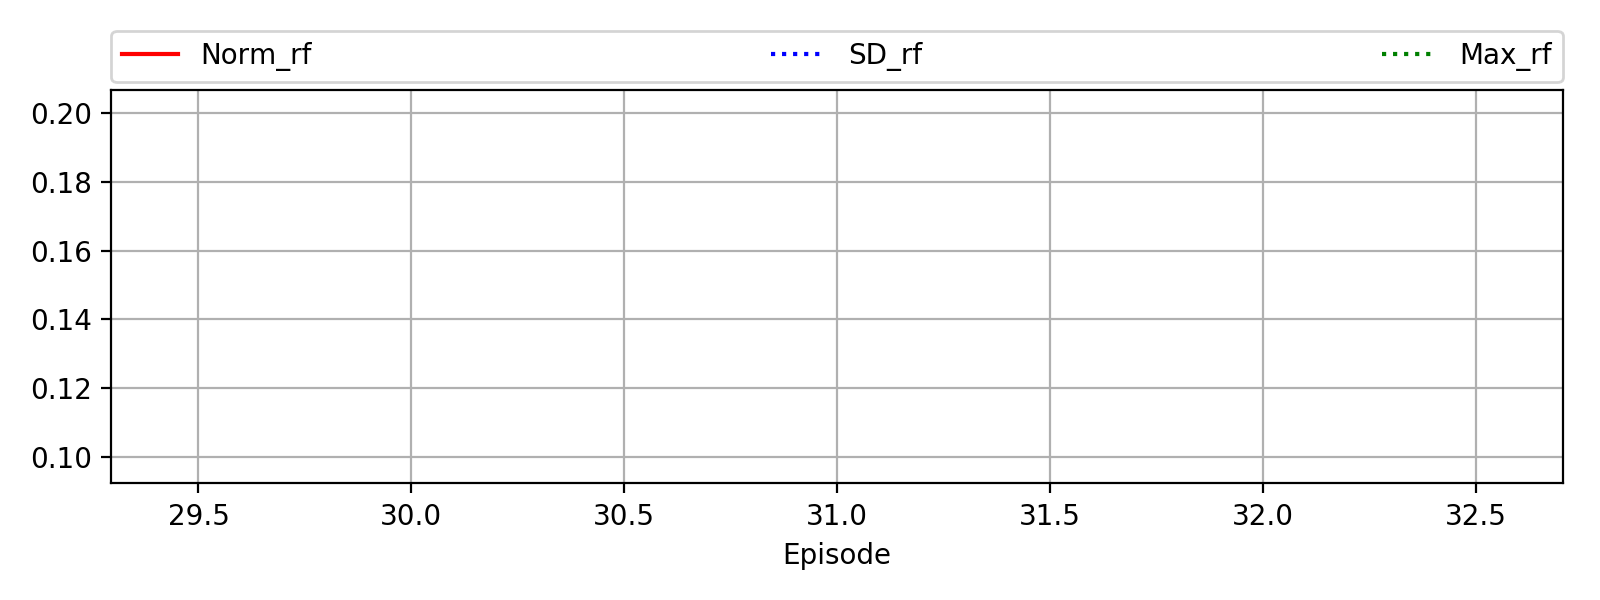

<IPython.core.display.Javascript object>


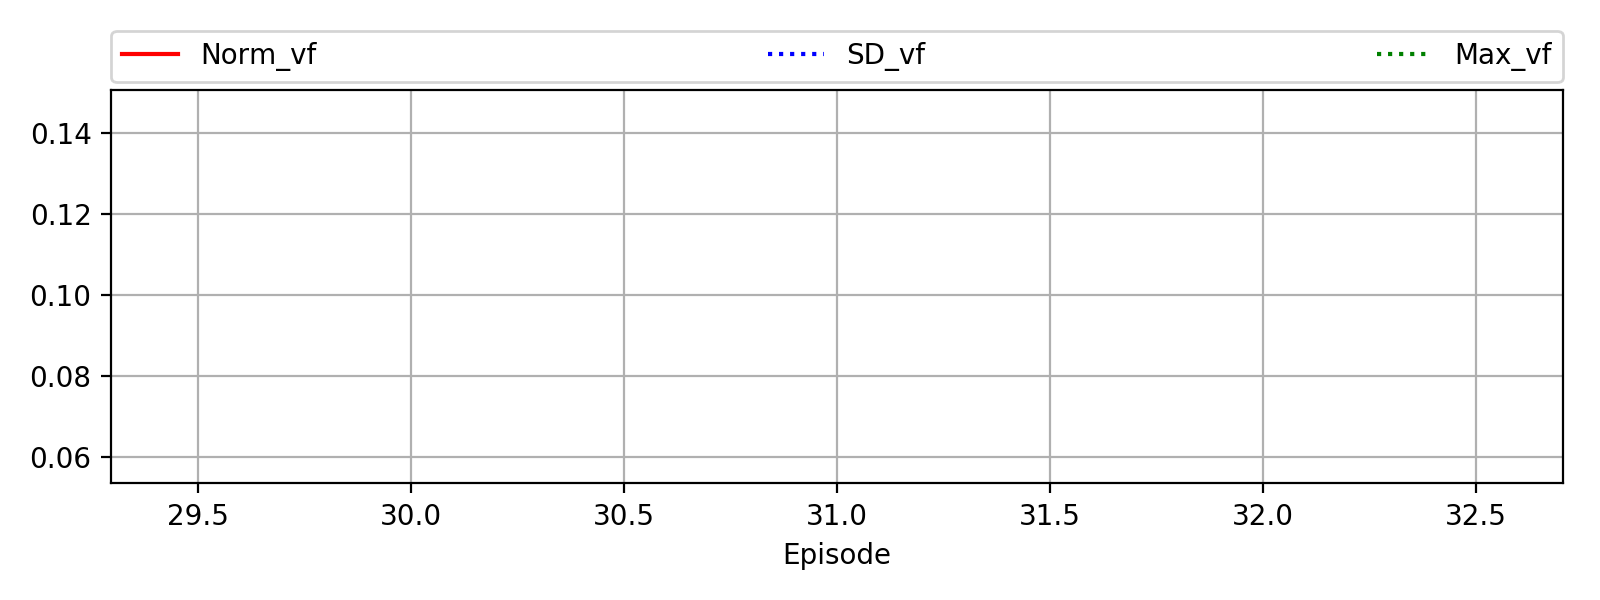

Lander Env
Landing_icgen:
    adjust_apf_v0               :  False
    w (min/max)                 :  (-0.0011, -0.0011, -0.0011) (0.0011, 0.0011, 0.0011)
 mass (min/max)                 :  450 500
  srp (min/max)                 :  (-1e-06, -1e-06, -1e-06) (1e-06, 1e-06, 1e-06)
M (min/max)                     :  (20000000000.0, 200000000000.0)
Position Theta                  :  (0, 0.7853981633974483)
Position Phi                    :  (-3.141592653589793, 3.141592653589793)
[[-1.]
 [ 0.]
 [ 1.]]
Value Funtion
	xn_init: layer  Linear(in_features=6, out_features=60, bias=True)
	xn_init: layer  GRUCell(60, 17)
	xn_init: layer  Linear(in_features=17, out_features=5, bias=True)
	xn_init: layer  Linear(in_features=5, out_features=1, bias=True)
Value Function: recurrent steps > 1, disabling shuffle and batching
	Clip Range:         0.5
	Shuffle :           False
	Batch Size :        9999999
	Max Grad Norm:      30
	Recurrent Steps:    60
	Rollout Limit:      1
Agent
Dynamics: Max Disturbanc

In [11]:
from env import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen_sphere import Landing_icgen
import rl_utils

from arch_policy_vf import Arch

from policy_drdv_pulsed import Policy
from value_function import Value_function


import policy_nets as policy_nets
import valfunc_nets as valfunc_nets

from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from reward_terminal_mdr import Reward


logger = rl_utils.Logger()
dynamics_model = Dynamics_model(landing_target=np.asarray([0., 0., 250.]))
lander_model = Lander_model(apf_tau1=300, apf_tau2=300, apf_vf1=-0.2, apf_vf2=-0.01, apf_atarg=20, apf_v0=1.0)
lander_model.min_thrust = 0
lander_model.max_thrust = 2
lander_model.get_state_agent = lander_model.get_state_agent1
lander_model.apf_pot = lander_model.apf_pot2
obs_dim = 6
act_dim = 3
recurrent_steps = 60

reward_object = Reward(landing_coeff=10.0, landing_rlimit=1, landing_vlimit=0.2, 
                       tracking_coeff=-1.00, fuel_coeff=-0.01, landing_gslimit=-1)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          tf_limit=3000.0,print_every=10,
           nav_period=6)


min_w   = -1.1e-3
max_w   =  1.1e-3

env.ic_gen = Landing_icgen(adjust_apf_v0=False,
                            position_theta=(0,np.pi/4),
                            min_mass = 450, max_mass=500,
                            min_w=(min_w,min_w,min_w),  max_w=(max_w,max_w,max_w))
                            

                            
                          
                           
env.ic_gen.show()

arch = Arch()

policy = Policy(env, pulsed=True)
value_function = Value_function(valfunc_nets.GRU(obs_dim, recurrent_steps=recurrent_steps), 
                                shuffle=False, batch_size=9999999, max_grad_norm=30)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, lam=0.98, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
agent.train(1)

# Test Policy 

In [12]:
print(1)
policy.test_mode=True   
env.test_policy_batch(agent,5000,print_every=100)

1
Dynamics: Max Disturbance (m/s^2):  [0.00423785 0.00462301 0.00337051] 0.007119827064607943
Dynamics: Max w:                    [0.00097177 0.00073481 0.00101763]
i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.55 |  0.69 |  0.00 |  3.46 |     0
glideslope | 8.836 |24.319 | 0.178 |785.768 |     6
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.086 |   0.112 |   0.012 |   0.807
norm_rf  |     0.7 |     3.6 |     0.0 |    31.1
position |    -0.4    -0.3    -0.0 |     2.5     2.6     0.0 |   -21.6   -22.4    -0.2 |     2.6     8.8    -0.0
velocity |   0.004   0.006  -0.075 |   0.048   0.049   0.098 |  -0.135  -0.166  -0.693 |   0.273   0.312  -0.010
fuel     |  1.24 |  0.14 |  0.99 |  1.62
glideslope |  4.34 |  3.42 |  1.05 | 19.15
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.54 |  0.69 |  0.00 |  3.46 |     0
glideslope | 9.027 |23.541 | 0.178 |785.768 |     6
sc_margin |100.000 | 0.000 |100.000 |100.000

Dynamics: Max Disturbance (m/s^2):  [0.005163   0.00579079 0.00515576] 0.009315133381093155
Dynamics: Max w:                    [ 1.04387283e-03 -5.59123698e-05 -1.01955023e-03]
i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.54 |  0.69 |  0.00 |  3.46 |     0
glideslope | 9.344 |23.222 | 0.015 |2365.323 |   562
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.076 |   0.079 |   0.005 |   0.807
norm_rf  |     0.4 |     1.9 |     0.0 |    36.9
position |    -0.0     0.0    -0.0 |     1.4     1.3     0.0 |   -21.6   -22.4    -0.2 |    28.5    23.4    -0.0
velocity |   0.001  -0.002  -0.067 |   0.036   0.037   0.070 |  -0.384  -0.290  -0.693 |   0.273   0.312  -0.002
fuel     |  1.25 |  0.18 |  0.86 |  2.32
glideslope |  4.95 |  6.62 |  0.36 |134.57
Dynamics: Max Disturbance (m/s^2):  [0.005163   0.00579079 0.00515576] 0.009315133381093155
Dynamics: Max w:                    [ 1.04387283e-03 -5.59123698e-05 -1.01955023e-03]


i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.54 |  0.69 |  0.00 |  3.46 |     0
glideslope | 9.340 |23.176 | 0.015 |2794.558 |  1692
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.076 |   0.080 |   0.003 |   0.813
norm_rf  |     0.4 |     2.1 |     0.0 |    44.0
position |    -0.0     0.0    -0.0 |     1.6     1.5     0.0 |   -21.6   -27.5    -0.3 |    34.4    23.4    -0.0
velocity |   0.001  -0.001  -0.066 |   0.038   0.037   0.071 |  -0.408  -0.377  -0.693 |   0.312   0.325  -0.001
fuel     |  1.25 |  0.18 |  0.86 |  2.32
glideslope |  4.89 |  5.94 |  0.36 |134.57
Dynamics: Max Disturbance (m/s^2):  [0.005163   0.00579079 0.00515576] 0.009315133381093155
Dynamics: Max w:                    [ 1.04387283e-03 -5.59123698e-05 -1.01955023e-03]
i :  2400
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.54 |  0.69 |  0.00 |  3.46 |     0
glideslope | 9.332 |23.149 | 0.015 |2794.558 |  1692
sc_margin |100.000 | 0.000 

Dynamics: Max Disturbance (m/s^2):  [0.00524846 0.00579079 0.00515576] 0.009362770832618559
Dynamics: Max w:                    [0.00106616 0.00105619 0.0007797 ]
i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.54 |  0.69 |  0.00 |  3.46 |     0
glideslope | 9.328 |23.156 | 0.015 |2794.558 |  1692
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.076 |   0.079 |   0.003 |   0.813
norm_rf  |     0.4 |     2.0 |     0.0 |    44.0
position |    -0.1    -0.0    -0.0 |     1.4     1.4     0.0 |   -21.6   -27.5    -0.3 |    34.4    23.4    -0.0
velocity |   0.002  -0.000  -0.066 |   0.037   0.036   0.070 |  -0.408  -0.377  -0.693 |   0.312   0.348  -0.001
fuel     |  1.25 |  0.18 |  0.86 |  2.46
glideslope |  4.95 |  6.20 |  0.36 |134.57
i :  3500
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.54 |  0.69 |  0.00 |  3.46 |     0
glideslope | 9.351 |23.323 | 0.015 |2794.558 |  1692
sc_margin |100.000 | 0.000 |100.000 |100.0

i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.54 |  0.69 |  0.00 |  3.46 |     0
glideslope | 9.349 |23.222 | 0.015 |2794.558 |  1692
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.075 |   0.077 |   0.003 |   0.857
norm_rf  |     0.3 |     1.9 |     0.0 |    44.0
position |    -0.1     0.0    -0.0 |     1.4     1.4     0.0 |   -24.0   -35.5    -0.3 |    34.4    23.4    -0.0
velocity |   0.002  -0.000  -0.065 |   0.035   0.036   0.069 |  -0.408  -0.377  -0.710 |   0.312   0.401  -0.001
fuel     |  1.25 |  0.18 |  0.86 |  2.46
glideslope |  4.97 |  7.01 |  0.16 |241.79
Dynamics: Max Disturbance (m/s^2):  [0.00528625 0.00583471 0.00515576] 0.009411171512466926
Dynamics: Max w:                    [0.00106616 0.00105619 0.0007797 ]
i :  4600
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.54 |  0.69 |  0.00 |  3.46 |     0
glideslope | 9.349 |23.312 | 0.015 |2794.558 |  1692
sc_margin |100.000 | 0.000 |100.000 |100.0